# TotalChi2 and SN Ia standardisation

The is an extension of the [total_chi2](total_chi2.ipynb) notebook such that

`mag = M + alpha*x1 + beta*c`.

In this example, `M`, `alpha` and `beta` are free parameters (to be recovered) and `mag`, `x1` and `c` are observed parameter with errorbars. 

In [1]:
from scipy import stats
import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

Let's draw x1 and c for some non-gaussian function

## The simulation function

In [2]:
x1_func = stats.beta(**{"a":18,"b":7, "loc":-10, "scale":13})
c_func = stats.alpha(**{"a":3.68676,"loc":-0.427, "scale":1.696})

In [3]:
def get_snia_mock(size=1000, magabs=-19.3, 
                  alpha=-0.15, beta=3.15, 
                 mag_err = 0.15, x1_err=0.2, c_err=0.05):
    """ get a simulated data

    Parameters
    ----------
    size: int
        number of point in the simulation

    A, B: float
        linear relation parameters such that y=A*x + b

    x_err, y_err: float, array
        error on observed parameters (must broadcast with size).

    Returns
    -------
    (x, y), (x_true, y_true)
        observed and true parameters (you never have access to in real observations)
    """
    import numpy as np
    # ------------- #
    # modelisation  #
    # ------------- #
    # This is the true x parameter (i.e., noise free)
    x1_true = x1_func.rvs(size)
    c_true = x1_func.rvs(size)
    
    # y is related to the true parameter 
    mag_true = magabs + x1_true*alpha + c_true*beta
    
    # now, both are noisy, so
    x1 = x1_true + np.random.normal(size=size, loc=0, scale=x1_err)
    c = c_true + np.random.normal(size=size, loc=0, scale=c_err)
    mag = mag_true + np.random.normal(size=size, loc=0, scale=mag_err)
    return (mag, x1, c)

## The loss model (total chi2)

In [4]:
def get_totalchi2(params, mag_data, x1_data, c_data, 
                  mag_err, x1_err, c_err):
    """ """
    # parse the input
    alpha_fit, beta_fit, magabs_fit  = params["coefs"]
    (x1_model, c_model) = params["xtrue"]

    # mag_model from x1_model and c_model (“_model“ for fitting the truth)
    mag_model = magabs_fit + alpha_fit*x1_model + beta_fit*c_model

    # chi2 on mag
    chi2_mag = jnp.sum( (mag_model - mag_data)**2 /  mag_err**2 )

    # chi2 on nuisance
    chi2_x1 = jnp.sum( (x1_model - x1_data)**2 /  x1_err**2 )
    chi2_c = jnp.sum( (c_model - c_data)**2 /  c_err**2 )
    
    # x_true_fit constrained by x_data given x_err
    return 1/3 * (chi2_mag + chi2_x1 + chi2_c)

## The fitter

In [5]:
def fit_adam(func_,  param_init, 
             learning_rate = 5e-3, niter = 3_000,
             tol = 1e-3, **kwargs):
    """ """
    import optax
    # let's make sure they are jax array
   
    # Initialize the adam optimizer
    params = param_init
    optimizer = optax.adam(learning_rate)
    
    # Obtain the `opt_state` that contains statistics for the optimizer.
    opt_state = optimizer.init(params)
    
    # magic of jax ! here is hte gradiant function
    grad_func = jax.jit(jax.grad( func_ )) 
    
    # let's store the loss to see.
    losses = []
    for i in range(niter):
        current_grads = grad_func(params, **kwargs)
        updates, opt_state = optimizer.update(current_grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append( func_(params, **kwargs) ) # store the loss function
        if tol is not None and (i>2 and ((losses[-2] - losses[-1]) < tol)):
            break

    return params, losses

## Together

In [6]:
model_in = dict(magabs=-19.3, alpha=-0.15, beta=3.15,
                mag_err = 0.15, x1_err=0.2, c_err=0.05)
mag, x1, c = get_snia_mock(size=1_000, **model_in)
mag = jnp.asarray(mag, dtype="float32")
x1 = jnp.asarray(x1, dtype="float32")
c = jnp.asarray(c, dtype="float32")

initial_guess

In [7]:
param_init = {"coefs": jnp.asarray([-0.1, 3.7, -18.5], dtype="float32"),
             "xtrue": [x1.copy(), c.copy()]}

In [8]:
params, losses = fit_adam(get_totalchi2, param_init=param_init,
                           learning_rate=1e-3, niter=10_000,
                        # and function inputs
                        mag_data=mag, x1_data=x1, c_data=c, 
                        mag_err=model_in.get("mag_err"), 
                        x1_err=model_in.get("x1_err"), 
                        c_err=model_in.get("c_err"), 
                        )

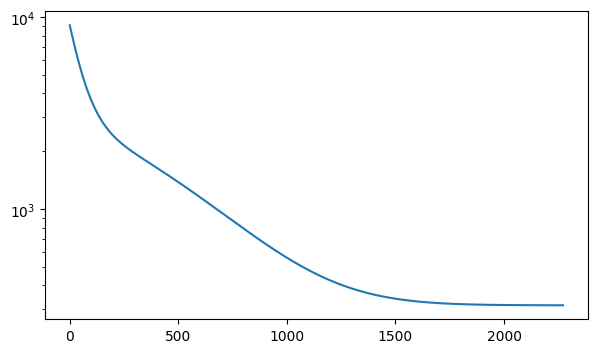

In [9]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(losses)
ax.set_yscale("log")

In [10]:
params["coefs"]

Array([ -0.15031593,   3.148503  , -19.305626  ], dtype=float32)